In [1]:
import numpy as np
def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad**2)
    total_norm = np.sqrt(total_norm)
    
    rate = max_norm / (total_norm + 1e-7)
    if rate < 1:
        for grad in grads:
            grad *= rate

In [2]:
import numpy as np
from util import sigmoid

class LSTM:
    def __init__(self, W_x, W_h, b):
        # W_x : D x 4H
        # W_h : H x 4H
        # b : H x 1
        self.params = [W_x, W_h, b]
        self.grads = [np.zeros_like(W_x), np.zeros_like(W_h), np.zeros_like(b)]
        self.cache = None
        
    def forward(self, x, h_prev, c_prev):
        W_x, W_h, b = self.params
        _, H = h_prev.shape

        affine_res = np.matmul(x, W_x) + np.matmul(h_prev, W_h) + b # N x H
        
        f = sigmoid(affine_res[:, :H])
        g = np.tanh(affine_res[:, H:2*H])
        i = sigmoid(affine_res[:, 2*H:3*H])
        o = sigmoid(affine_res[:, 3*H:])
        
        c_next = (c_prev * f) + (g * i)
        h_next = np.tanh(c_next) * o
        
        self.cache = (x, h_prev, c_prev, f, g, i, o , c_next, h_next)
        
        return h_next, c_next
        
    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, f, g, i, o, c_next, h_next = self.cache

        dintermediate = (dc_next + (dh_next * o) * (1 - np.tanh(c_next)**2))
        dc_prev = dintermediate * f

        do = dh_next * np.tanh(c_next)
        di = dintermediate * g
        dg = dintermediate * i
        df = dintermediate * c_prev

        # d/dx * sigomoid(x) = sigmoid(x) * (1-sigmoid(x))
        # d/dx * tanh(x) = 1 - tanh(x)**2
        di *= i * (1 - i) # N x H
        df *= f * (1 - f) # N x H
        do *= o * (1 - o) # N x H
        dg *= (1 - g**2)  # N x H

        dA = np.hstack((df, dg, di, do)) # dA: N x 4H

        db = dA.sum(axis=0)
        dW_x = np.dot(x.T, dA)
        dW_h = np.dot(h_prev.T, dA)

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        self.grads[0][...] = dW_x
        self.grads[1][...] = dW_h
        self.grads[2][...] = db

        return dx, dh_prev, dc_prev

In [3]:
class TimeLSTM:
    def __init__(self, W_x, W_h, b, stateful=True):
        self.params = [W_x, W_h, b]
        self.grads = [np.zeros_like(W_x), np.zeros_like(W_h), np.zeros_like(b)]
        self.stateful = stateful
        
        self.h, self.dh = None, None
        self.c, self.dc = None, None
        self.layers = []
    
    def set_state(self, h, c):
        self.h = h
        self.c = c
        
    def reset_state(self):
        self.h = None
        self.c = None
        
    def forward(self, xs):
        W_x, W_h, b = self.params
        N, T, D = xs.shape
        H, _ = W_h.shape
        
        hs = []
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='float')
        
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='float')
            
            
        for i in range(T):
            lstm = LSTM(W_x, W_h, b)

            self.h, self.c = lstm.forward(xs[:, i, :], self.h, self.c)
            hs.append(self.h)
            
            #hs[:, i, :] = self.h
            self.layers.append(lstm)
        
        return np.array(hs).transpose(1, 0, 2)
    
    def backward(self, dhs):
        _, T, _ = dhs.shape
        
        dxs = []
        dh_next = 0
        dc_next = 0
        for i in range(len(self.grads)):
            self.grads[i][...] = 0
            
        for i in range(T-1, -1, -1):
            dh_cur = dhs[:, i, :]
            dx, dh_prev, dc_prev = self.layers[i].backward(dh_cur + dh_next, dc_next)
            dxs.append(dx)
            
            for j, grad in enumerate(self.layers[i].grads):
                self.grads[j] += grad
                
            dh_next = dh_prev
            dc_next = dc_prev
            
        self.dh = dh_prev
        self.dc = dc_prev
        return np.flip(np.array(dxs), axis=0)

In [4]:
import numpy as np
from layer import TimeEmbedding, TimeAffine, TimeSoftmaxWithLoss

class RNNLM:
    def __init__(self, vocab_size, embedding_size, hidden_size):
        self.D = embedding_size
        self.H = hidden_size
        self.V = vocab_size
        self.params = []
        self.grads = []
        self.logit = None

        self.W_embed = (0.01 * np.random.randn(self.V, self.D)).astype('float32')
        self.W_x_lstm = ((1 / np.sqrt(self.D)) * np.random.randn(self.D, 4*self.H)).astype('float32')
        self.W_h_lstm = ((1 / np.sqrt(self.H)) * np.random.randn(self.H, 4*self.H)).astype('float32')
        self.b_lstm = np.zeros(4*self.H).astype('float32')
        self.W_affine = ((1 / np.sqrt(self.H)) * np.random.randn(self.H, self.V)).astype('float32')
        self.b_affine = np.zeros(self.V).astype('float32')

        self.layers = []
        self.layers.append(TimeEmbedding(self.W_embed))
        self.layers.append(TimeLSTM(self.W_x_lstm, self.W_h_lstm, self.b_lstm))
        self.layers.append(TimeAffine(self.W_affine, self.b_affine))
        self.last_layer = TimeSoftmaxWithLoss()

        for layer in self.layers:
            for param, grad in zip(layer.params, layer.grads):
                self.params.append(param)
                self.grads.append(grad)

    def predict(self, xs):
        out = xs
        for layer in self.layers:
            out = layer.forward(out)
        
        self.logit = out
        return self.logit
    
    def forward(self, xs, ts):
        logit = self.predict(xs)
        loss = self.last_layer.forward(logit, ts)
        return loss

    def backward(self):
        dout = self.last_layer.backward().astype('float32')
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.layers[1].reset_state()
        
    def save_params(self, file_name):
        np.save(file_name, self.params)
        
    def load_params(self, file_name):
        params = np.load(file_name)
        for i, param in enumerate(params):
            self.params[i][...] = param

In [5]:
from optimizer import SGD
from trainer import RnnlmTrainer
from dataset import ptb

def check_corpus_vs_vocab(corpus, word_to_id):
    max_id = max(corpus)
    vocab_size = len(word_to_id)

    print(f"📌 max ID in corpus      : {max_id}")
    print(f"📌 vocabulary size       : {vocab_size}")

    if max_id >= vocab_size:
        print("⚠️  Warning: corpus contains IDs outside word_to_id dictionary!")
        missing_ids = [i for i in set(corpus) if i >= vocab_size]
        print(f"   ➤ Missing IDs: {missing_ids}")
    else:
        print("✅ All corpus IDs are within vocabulary range.")
        
batch_size = 20
wordvec_size = 100
hidden_size = 100
time_size = 35
lr = 20.0
#max_epoch = 4
max_epoch = 2
max_grad = 0.25

corpus, word_to_id, id_to_word = ptb.load_data('train')
check_corpus_vs_vocab(corpus, word_to_id)
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = RNNLM(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)


📌 max ID in corpus      : 9999
📌 vocabulary size       : 10000
✅ All corpus IDs are within vocabulary range.
| epoch 1 | iter 20/1327 | perplexity 2688.55
| epoch 1 | iter 40/1327 | perplexity 1735.97
| epoch 1 | iter 60/1327 | perplexity 1248.45
| epoch 1 | iter 80/1327 | perplexity 1213.49
| epoch 1 | iter 100/1327 | perplexity 1060.99
| epoch 1 | iter 120/1327 | perplexity 1104.15
| epoch 1 | iter 140/1327 | perplexity 1090.46
| epoch 1 | iter 160/1327 | perplexity 1029.33
| epoch 1 | iter 180/1327 | perplexity 1072.28
| epoch 1 | iter 200/1327 | perplexity 1044.37
| epoch 1 | iter 220/1327 | perplexity 1050.28
| epoch 1 | iter 240/1327 | perplexity 1000.05
| epoch 1 | iter 260/1327 | perplexity 1053.11
| epoch 1 | iter 280/1327 | perplexity 1008.62
| epoch 1 | iter 300/1327 | perplexity 1020.27
| epoch 1 | iter 320/1327 | perplexity 851.65
| epoch 1 | iter 340/1327 | perplexity 979.03
| epoch 1 | iter 360/1327 | perplexity 1021.23
| epoch 1 | iter 380/1327 | perplexity 983.22
| epo

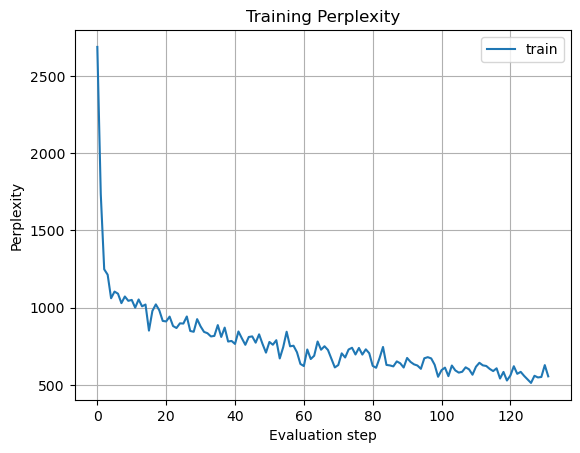

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6,) + inhomogeneous part.

In [7]:
trainer.plot()
model.save_params('rnnlm_params.npy')